# The Problem

In recent years there have been significant reductions in local authority funding,
and budgets have been reduced accordingly.
Cutting spending on preventative measures like early help in schools, quality of life
improvements for elderly and disabled residents, could lead to having to spend
more later to fix more severe problems as a result.
Using a sample spending dataset from a local authority, design a model to test this
theory. (Look for ‘Spend over £500’ open data).
Remember:
* What question are you answering?
* If you had an answer, what would it look like?
* What data would be relevant?
* What are the principal components?

# Import Libraries

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from sklearn.cluster import KMeans

# Import data and save it as a `.pkl` file

With the code below I converted the data type in a few of the columns and then saved the dataframe as a `.pkl` file. This will allow me to import the data more easily when performing other analyses (especially when using other notebooks).

In [30]:
# import the over £500 dataset that we sorted and cleaned previously

df = pd.read_csv('./spending_data/bristol_spending_data_final.csv')

# convert  the transaction amounts to numeric values rather than strings.
# set non numeric values to n/a with errors=coerce.
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# convert the date to a datetime object
df['Pay Date']= pd.to_datetime(df['Pay Date'], format='%d/%m/%Y')

# check the df
print(df.info())

# Write to pickle pickle file
with open('./pkl_data/bristol_spending_data.pkl', 'wb') as pickle_file:
    pickle.dump(df, pickle_file)

/var/folders/t7/n_c5tq1n0h985pbhlhf2w0c80000gn/T/ipykernel_35012/3295020594.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./spending_data/bristol_spending_data_final.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022713 entries, 0 to 1022712
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Supplier       1022713 non-null  object        
 1   Amount         1022712 non-null  float64       
 2   Pay Date       1022713 non-null  datetime64[ns]
 3   Description 1  1022705 non-null  object        
 4   Description 2  1018731 non-null  object        
 5   Description 3  834026 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 46.8+ MB
None


# Investigate and visualize the data

## Plots of spending against time

### Daily Spending

- I summed the transactions for each day in order to obtain a dataset of spending per day.
- I then wrote this file to a `.pkl` for use later on.

In [31]:
# create the daily data df
df_daily = df.groupby(pd.Grouper(key='Pay Date', freq='D')).sum().reset_index() # use reset_index to keep the column names

# Write pickle
with open('./pkl_data/bristol_spending_data_daily.pkl', 'wb') as pickle_file:
    pickle.dump(df_daily, pickle_file)

/var/folders/t7/n_c5tq1n0h985pbhlhf2w0c80000gn/T/ipykernel_35012/1673945522.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df.groupby(pd.Grouper(key='Pay Date', freq='D')).sum().reset_index() # use reset_index to keep the column names


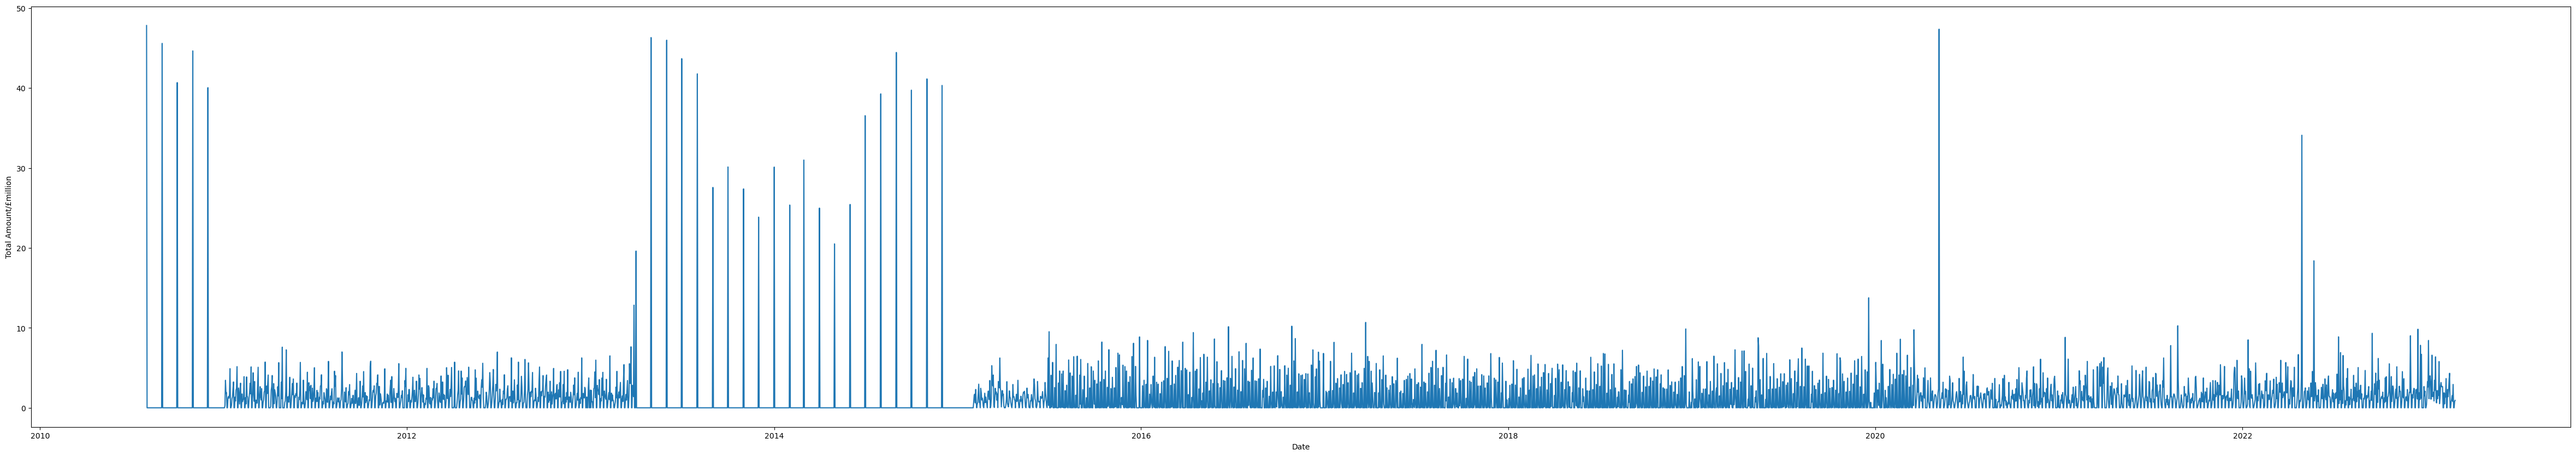

In [32]:
# Create a plot of the total transaction amounts by day
plt.figure(figsize=(60, 10))
plt.plot(df_daily['Pay Date'], df_daily['Amount']/1000000)
plt.xlabel('Date')
plt.ylabel('Total Amount/£million')

plt.show()

In this plot you can see where the transactions were only dated by month rather than day in 2010 and 2013-2015. There are also a few major peaks. The one in 2020 could be covid related grant payouts? 

### Plot the monthly data
Do the same thing as above but sum the transactions by month instead of day.

In [33]:
# plot the monthly data
df_monthly = df.groupby(pd.Grouper(key='Pay Date', freq='M')).sum().reset_index()

# Write pickle
with open('./pkl_data/bristol_spending_data_monthly.pkl', 'wb') as pickle_file:
    pickle.dump(df_monthly, pickle_file)

/var/folders/t7/n_c5tq1n0h985pbhlhf2w0c80000gn/T/ipykernel_35012/2552726086.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.groupby(pd.Grouper(key='Pay Date', freq='M')).sum().reset_index()


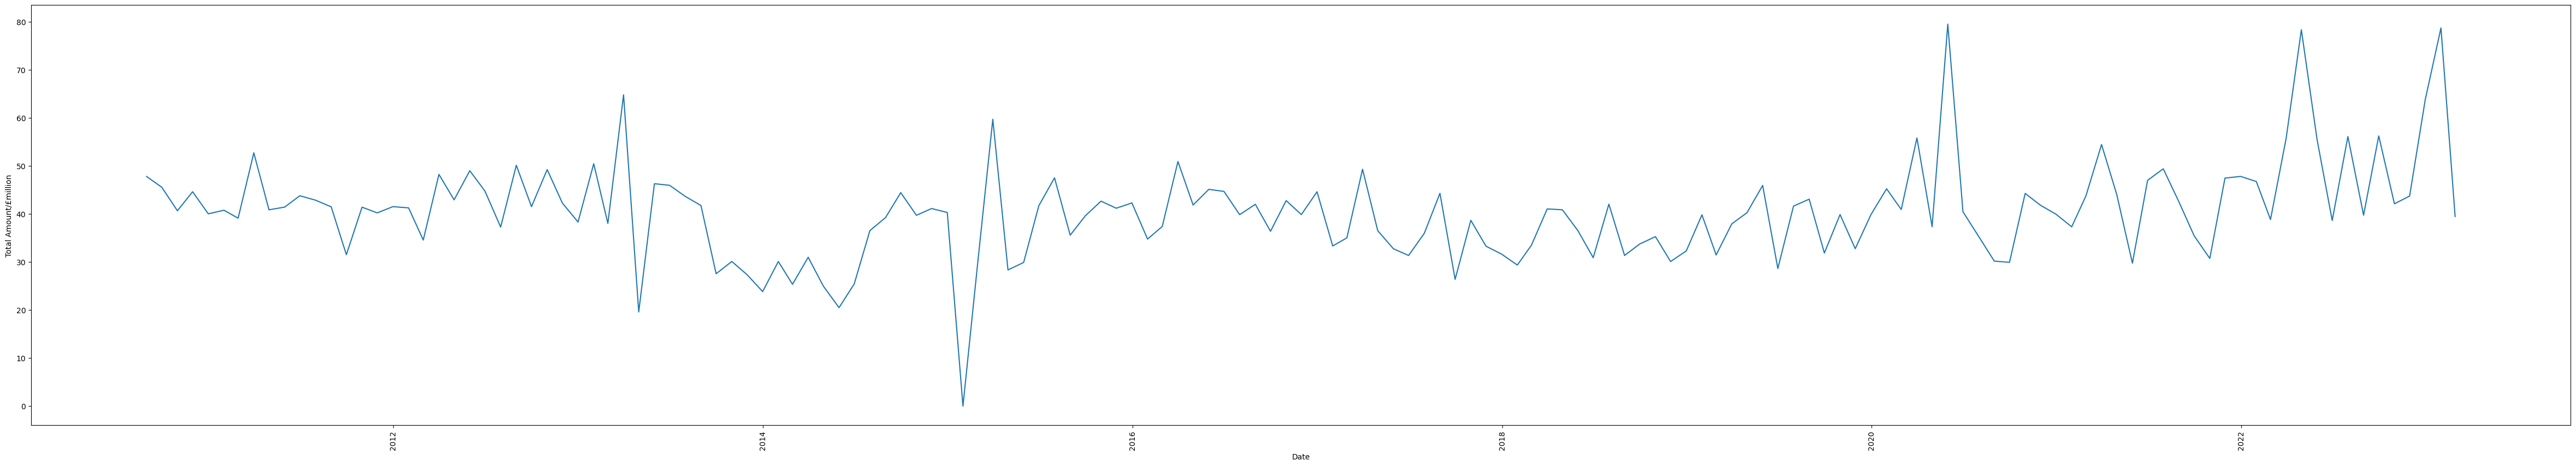

In [34]:
# Create a plot of the total transaction amounts by month
plt.figure(figsize=(60, 10))
plt.plot(df_monthly['Pay Date'], df_monthly['Amount']/1000000)
plt.xlabel('Date')
plt.ylabel('Total Amount/£million')
plt.xticks(rotation=90)
plt.show()



### Plot Yearly data

/var/folders/t7/n_c5tq1n0h985pbhlhf2w0c80000gn/T/ipykernel_35012/4289339400.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_yearly = df.groupby(pd.Grouper(key='Pay Date', freq='Y')).sum().reset_index()


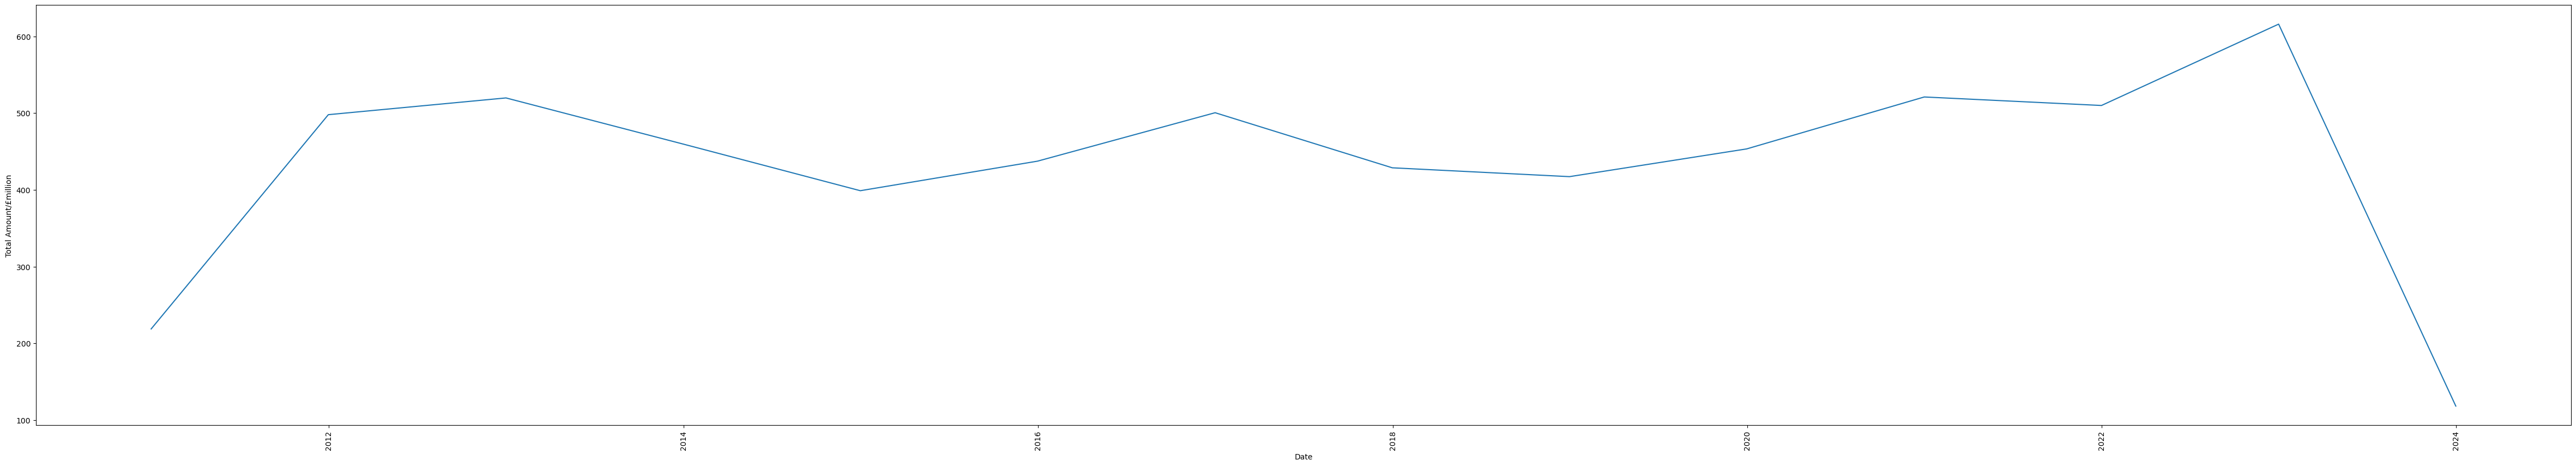

In [35]:
# plot the yearly data
df_yearly = df.groupby(pd.Grouper(key='Pay Date', freq='Y')).sum().reset_index()

# Create a plot of the total transaction amounts by month
plt.figure(figsize=(60, 10))
plt.plot(df_yearly['Pay Date'], df_yearly['Amount']/1000000)
plt.xlabel('Date')
plt.ylabel('Total Amount/£million')
plt.xticks(rotation=90)
plt.show()

# Adjust for inflation

As with any time series spending data it is useful to adjust for inflation so realistic spending trends can be obtained.

- I downloaded inflation data from the ONS. It is the [CPI INDEX 00: ALL ITEMS 2015=100 inflation data](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7bt/mm23).

- Their inflation datasets are calibrated to 2015. e.g. the inflation multiplier in 2015 is set to 100 and then adjusted to reduce values before 2015 (<100) and increase values after 2015 (>100) .

In [36]:

# import inflation data 
inflation_monthly = pd.read_csv('./inflation_data/CPI INDEX 00- ALL ITEMS 2015=100_monthly.csv')

# rename the paydate column to Month in the spending data
df_monthly.rename(columns={'Pay Date': 'Month'}, inplace=True)
# convert the datetime to a string which matches the inflation data 
df_monthly['Month'] = df_monthly['Month'].dt.strftime('%Y %b')
# now capatalize so it matches exactly
df_monthly['Month'] = df_monthly['Month'].str.upper()

# merge the inflation and spending dataframes
monthly_inflation_df = pd.merge(df_monthly, inflation_monthly, on='Month')

# calculate amount adjusted for inflation
# we need to divide by 100 as the ONS inflation is set to 100 for the baseline.
monthly_inflation_df['Adjusted_Amount'] = monthly_inflation_df['Amount'] * (monthly_inflation_df['Inflation']/100)

monthly_inflation_df.head()

,Month,Amount,Inflation,Adjusted_Amount
0,2010 AUG,47819035.83,89.8,4.294149e+07
1,2010 SEP,45583562.30,89.8,4.093404e+07
2,2010 OCT,40679091.82,90.0,3.661118e+07
3,2010 NOV,44644130.43,90.3,4.031365e+07
4,2010 DEC,40042877.84,91.2,3.651910e+07


## Plot of monthly spending adjusted for inflation
using CPI INDEX 00: ALL ITEMS 2015=100


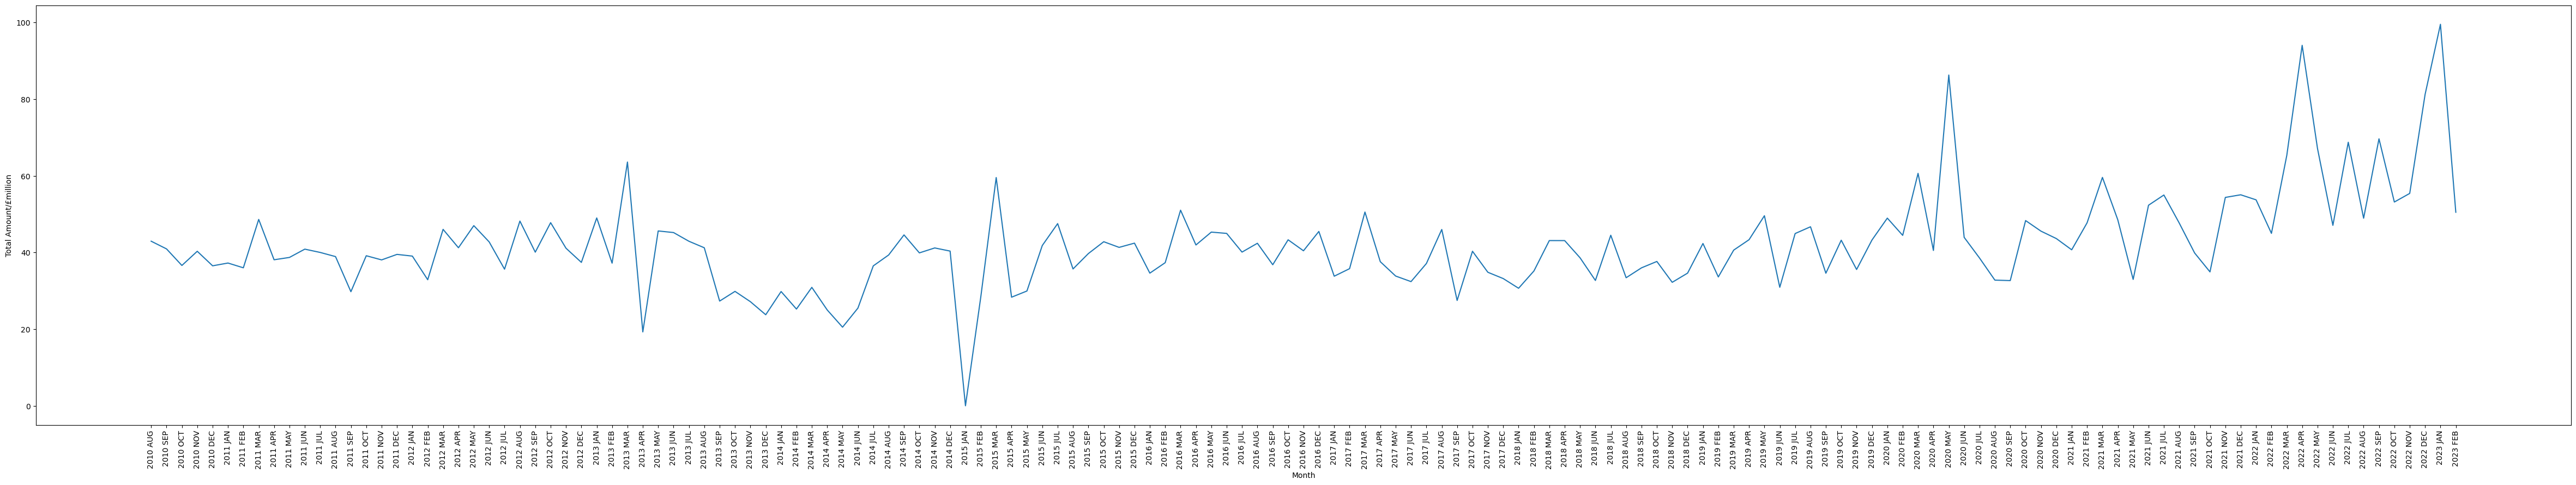

In [37]:
# Create a plot of the total transaction amounts by month
plt.figure(figsize=(60, 10))
plt.plot(monthly_inflation_df['Month'], monthly_inflation_df['Adjusted_Amount']/1000000)
plt.xlabel('Month')
plt.ylabel('Total Amount/£million')
plt.xticks(rotation=90)
plt.show()

### Combine the two graphs to see the difference inflation adjustment makes

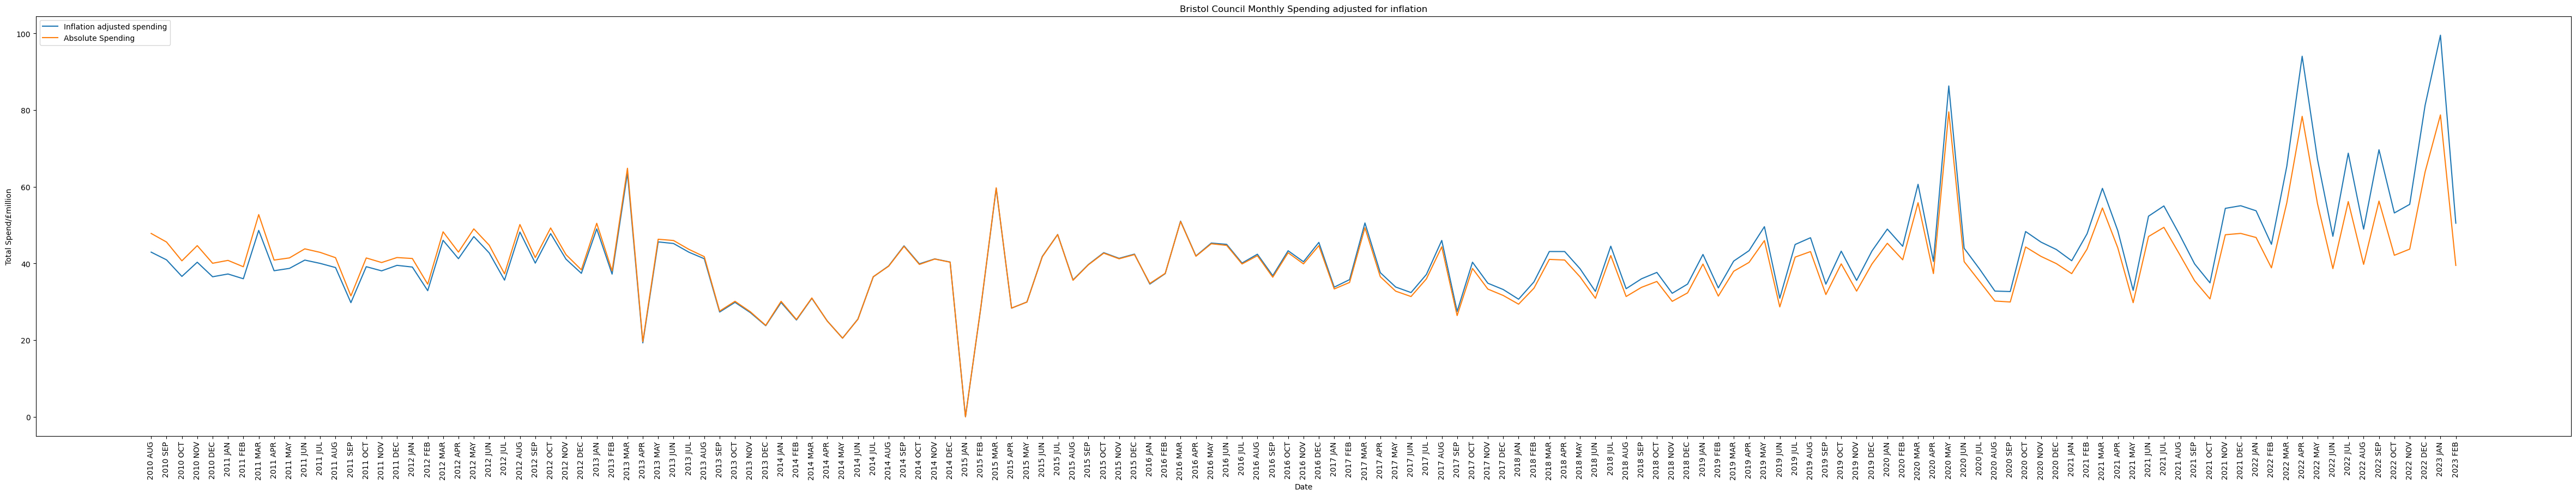

In [38]:
# create a figure with two subplots
fig, ax = plt.subplots(figsize=(60, 10))

# plot the first bar plot on the first subplot
ax.plot(monthly_inflation_df['Month'], monthly_inflation_df['Adjusted_Amount']/1000000, label='Inflation adjusted spending')
ax.plot(monthly_inflation_df['Month'], monthly_inflation_df['Amount']/1000000, label='Absolute Spending')
ax.legend()

# set the title and labels
ax.set_title('Bristol Council Monthly Spending adjusted for inflation')
ax.set_xlabel('Date')
ax.set_ylabel('Total Spend/£million')

plt.xticks(rotation=90)

plt.show()

## Inflation adjusted yearly spend data

In [39]:
df_yearly

,Pay Date,Amount
0,2010-12-31,2.187687e+08
1,2011-12-31,4.979037e+08
2,2012-12-31,5.197191e+08
3,2013-12-31,4.596152e+08
4,2014-12-31,3.988447e+08
5,2015-12-31,4.373357e+08
6,2016-12-31,5.004522e+08
7,2017-12-31,4.286898e+08
8,2018-12-31,4.171665e+08
9,2019-12-31,4.532924e+08


In [40]:
# import inflation data 
inflation_yearly = pd.read_csv('./inflation_data/CPI INDEX 00- ALL ITEMS 2015=100_yearly.csv')
inflation_yearly['Year'] = inflation_yearly['Year'].apply(str)

# rename the paydate column to Month in the spending data
df_yearly.rename(columns={'Pay Date': 'Year'}, inplace=True)
# convert the datetime to a string which matches the inflation data 
df_yearly['Year'] = df_yearly['Year'].dt.strftime('%Y')
# now capatalize so it matches exactly
df_yearly['Year'] = df_yearly['Year'].str.upper()

# merge the inflation and spending dataframes
yearly_inflation_df = pd.merge(df_yearly, inflation_yearly, on='Year')

# calculate amount adjusted for inflation
yearly_inflation_df['Adjusted_Amount'] = yearly_inflation_df['Amount'] * (yearly_inflation_df['Inflation']/100)

yearly_inflation_df.head()

,Year,Amount,Inflation,Adjusted_Amount
0,2010,2.187687e+08,89.4,1.955792e+08
1,2011,4.979037e+08,93.4,4.650420e+08
2,2012,5.197191e+08,96.1,4.994501e+08
3,2013,4.596152e+08,98.5,4.527210e+08
4,2014,3.988447e+08,100.0,3.988447e+08


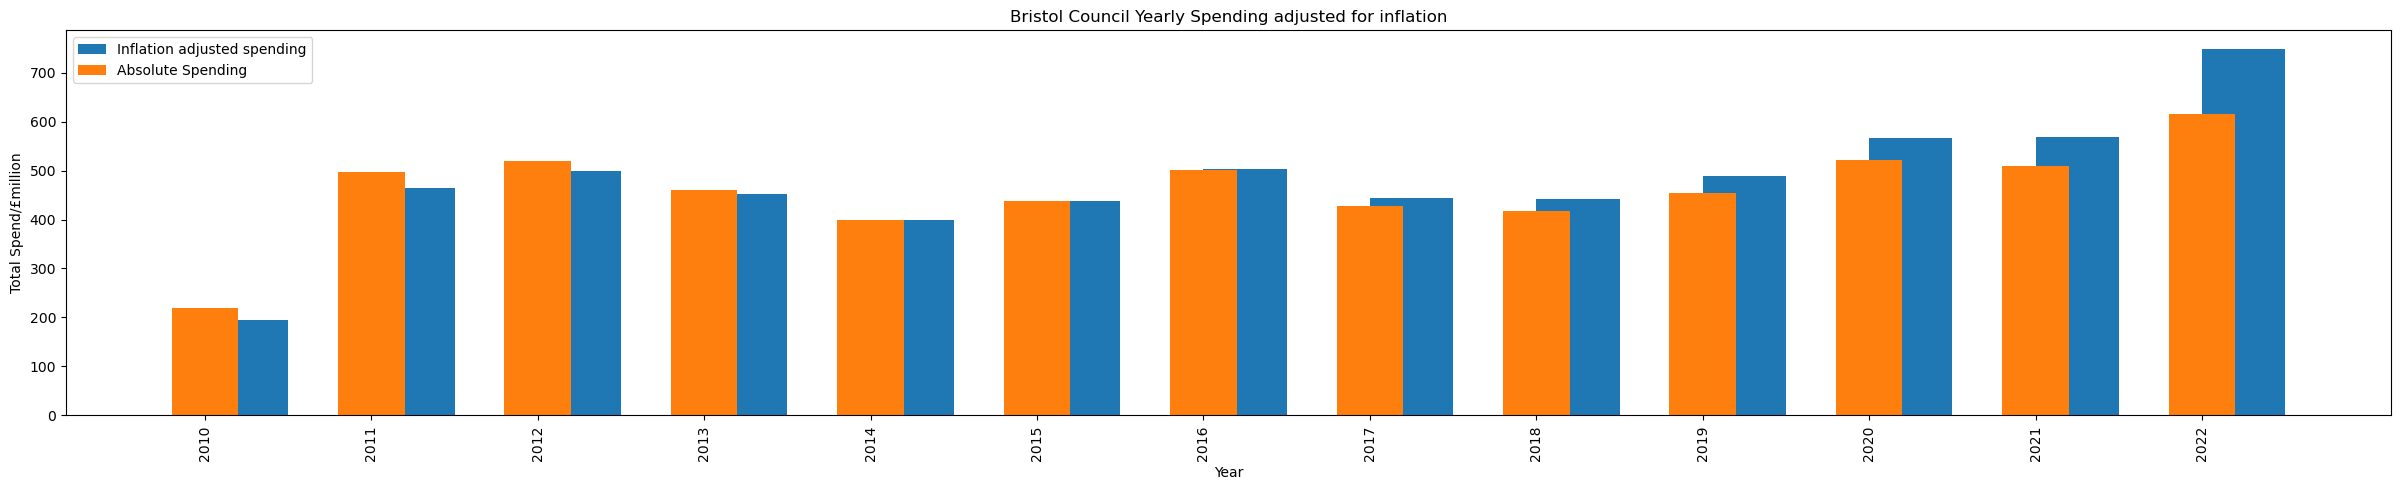

In [41]:
# create a figure with two subplots
fig, ax = plt.subplots(figsize=(30, 5))

# plot the first bar plot on the first subplot
ax.bar(yearly_inflation_df['Year'], yearly_inflation_df['Adjusted_Amount']/1000000, width=0.5, align='edge', label='Inflation adjusted spending')
ax.bar(yearly_inflation_df['Year'], yearly_inflation_df['Amount']/1000000, width=0.4, align='center', label='Absolute Spending')
ax.legend()

# set the title and labels
ax.set_title('Bristol Council Yearly Spending adjusted for inflation')
ax.set_xlabel('Year')
ax.set_ylabel('Total Spend/£million')


plt.xticks(rotation=90)

# display the figure
plt.show()

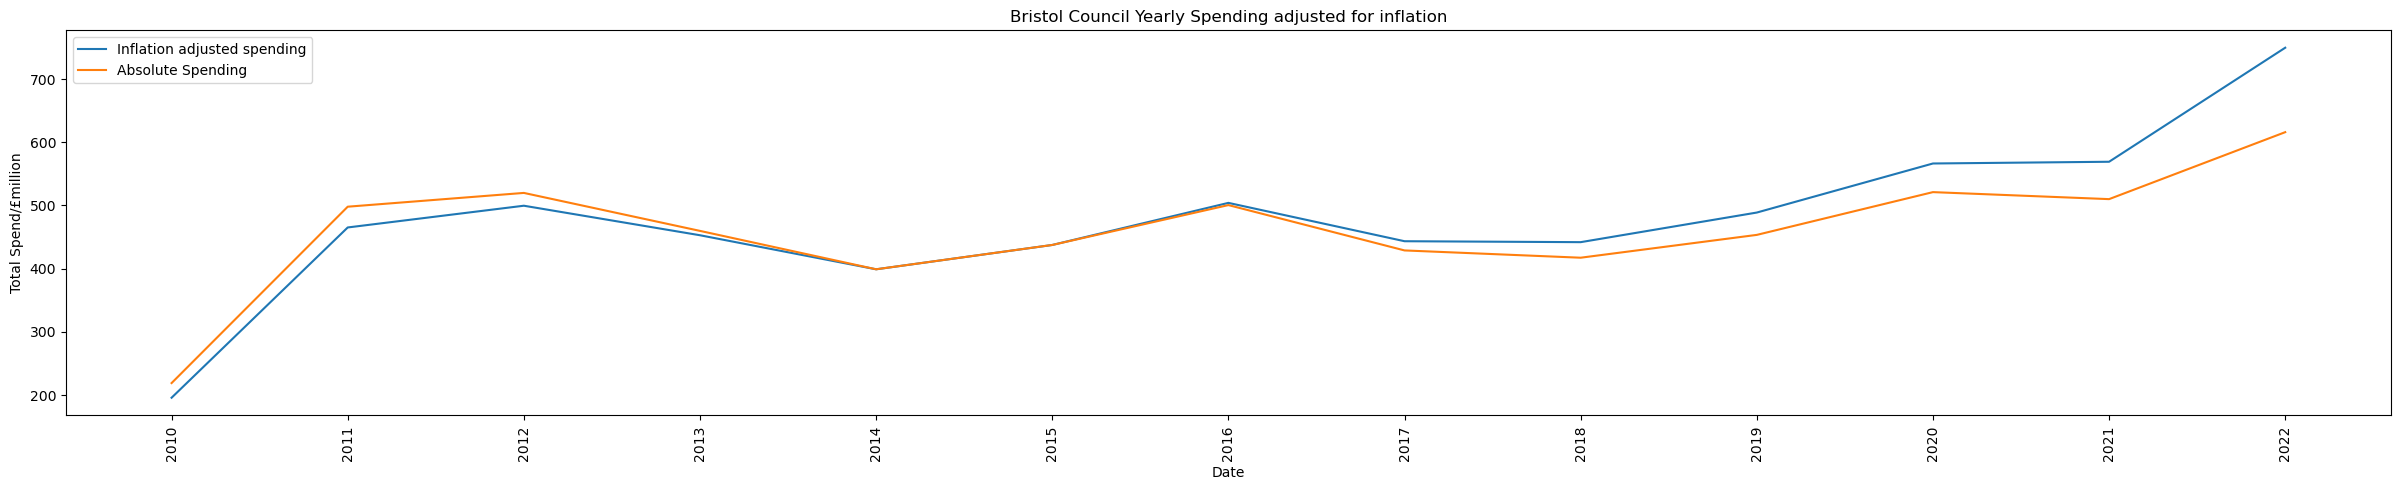

In [42]:
# Line Plot
fig, ax = plt.subplots(figsize=(30, 5))

# plot the two line plots
ax.plot(yearly_inflation_df['Year'], yearly_inflation_df['Adjusted_Amount']/1000000, label='Inflation adjusted spending')
ax.plot(yearly_inflation_df['Year'], yearly_inflation_df['Amount']/1000000, label='Absolute Spending')
ax.legend()

# set the title and labels
ax.set_title('Bristol Council Yearly Spending adjusted for inflation')
ax.set_xlabel('Date')
ax.set_ylabel('Total Spend/£million')


plt.xticks(rotation=90)

# display the figure
plt.show()
